# Question 4 + Visualization

In [4]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import itertools


## Loading datasets, creating a pandas dataframe for each file.

In [5]:
import pandas as pd
import networkx as nx
import itertools


tdist = pd.read_csv(r"CALtd.csv")
rdist = pd.read_csv(r"CALrd.csv")
nodexy = pd.read_csv(r"CALnodes.csv")

G1=nx.Graph()
G1.add_nodes_from(nodexy['id'])
edges1=rdist[['node1','node2']].values.tolist()
G1.add_edges_from(edges1)

G2=nx.Graph()
G2.add_nodes_from(nodexy['id'])
edges2=tdist[['node1','node2']].values.tolist()
G2.add_edges_from(edges2)

Gr = nx.dense_gnm_random_graph(20, 40, seed=None)

## Solution 1 Explained

The solution to this problem is at least NP-hard. Why? A similar problem studied in literature is the Hamiltonian path problem. This problem attempts to determine whether a Hamiltonian path (a path in an undirected or directed graph that visits each vertex exactly once). This problem is a NP-Complete problem. We attempt to solve this problem with a function MinRoute.
The first element of the function is the id of the starting node, then this is followed by the id's of the nodes that have to be visited, lastly one has to specify either distype = 1 or distype = 0 even though if the weights of the edges are to be assumed to be equal to one it won't matter whether the distance is time or length. The shortest distance will be the list with the shortest length.

Step 1: Making the networkx graph with nodes and egdes. Establishing whether the path is possible given the initial and final points using nx.has_path. If path is impossible, print "not possible".

Step 2 : Only 1 Node -

In the case there is only one starting node and one other node to be visited, the solution will simply be the shortest path between these 2 points, and in this case networkx module simply needs to call shortest_path and using dijkstra's algorithm the ouput will be a list representing the shortest path.

Step 3: Multiple intermediate nodes -

In the more complex case where there are multiple intermediate nodes to be visited the solution attempted is considerably harder and more inefficient.

i) The program first tries to rely on pure luck by using the shortest path algorithm with source = H and target = p_n. Once this shortest path is computed and stored as "slucky" then it checks if all the elements of p are in "slucky". If this is the case (very unlikely) then the solution is found.
    
ii)  In the case the input isn't "lucky" then the program goes on calculating all the paths connecting initial and final point. It creates a dataframe with a column for each of these paths. Then it checks if the intermediate nodes are all in present in these paths, then it returns the path with minimum length

Advantage: This method is precise and returns correct paths
Problem: With such a large dataset the function is computationally inefficient, so inefficient that it becomes unfeasible. Therefore we attempt a different solution later on.

    


## Solution 1 (small networks/brute force)

In [6]:
def MinRoute(H,*p,distype):
    nodelist = []
    paths = []
    
    for i in p:
        nodelist.append(i)
    
    if distype == 1:
        G= G1
        
    elif distype == 2:
        G = G2
        
    elif distype ==3:
        G = Gr
        
    if nx.has_path(G,H,nodelist[-1]) == False:
            print("No possible path")
            
    if len(nodelist) == 1:
            return nx.shortest_path(G,source= H, target =nodelist[0])
    elif len(nodelist) > 1:
        slucky = nx.shortest_path(G, source = H, target = nodelist[-1])
        if set(p) <= set(slucky):
            shortpaths = slucky
                         
        else:
            for path in nx.all_simple_paths(G,source = H, target = nodelist[-1]):
                if set(nodelist) <= set(path):
                    line = ','.join([str(p) for p in path])
                    paths.append(line)
            for i in range(len( paths )):
                paths[int(i)] = list(map(int, paths[int(i)].split(","))) 
            shortpaths = []
            a = min(paths, key=len)
            for el in range(len(paths)):
                if len(paths[el]) == len(a):
                    shortpaths.append(paths[el])
    
    return shortpaths


def drawShortPath(H,*sp, distypes):
    shortp = []
    for i in sp:
        shortp.append(i)
    k = list(MinRoute(H,*shortp,distype=distypes))
    
    a = list(k[0])
    if distypes == 3:    
        gs = Gr
    elif distypes == 1:
        gs = G1
    elif distypes == 2:
        gs == G2
    pos = nx.spring_layout(gs)
    
    
    
    color_map = []
    u_path = list(set(a))
    for i in range(len(u_path)):
        if i == 0:
            color_map.append('blue')
        elif i == len(u_path) - 1:
            color_map.append('red') 
        else: color_map.append('green')  
    nx.draw_networkx_nodes(gs, pos,nodelist = a, node_size=700,node_color=color_map)
    nx.draw_networkx_edges(gs,pos, nodelist = a, edgelist = gs.edges(),width=3)
    nx.draw_networkx_labels(gs, pos)
    plt.title('Shortest walk going through all nodes')
    plt.show()

    


//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
//anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


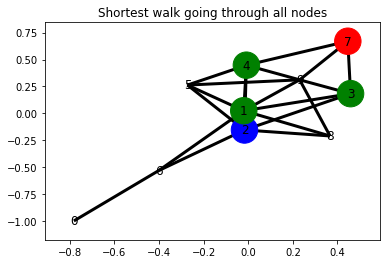

Shortest path going through all nodes [2, 3, 1, 4, 7]


In [7]:
Gr = nx.dense_gnm_random_graph(10, 20, seed=None)

k = list(MinRoute(2,3,4,7,distype=3))
drawShortPath(2,3,4,7,distypes=3)
print ("Shortest path going through all nodes" ,k[0])


## Output

Function "MinRoute" returns a list of lists with numbers representing the nodes of the shortest path possible between a set of points. Function "drawMR" then plots one of the shortest paths (they are all equivalent in length) and shows the starting node in blue, the ending node in red and all the in between nodes in green. Only the nodes that are traversed are labeled.

This function is not feasible with large n and e (number of nodes and egdes) but to prove its accuracy we create a small graph with random nodes and edges stored as Gr and execute the algorithms. By choosing distype = 3 both algorithms work on this small network (Gr).




# Solution 2 (Large Networks, Small p, Heuristical)

This Solution we came up with relies on dijkstra's algorithm for the shortest path and the intuition that if we were to cross all the points in some order, this order would depend on the shortest possible path passing between all these points. Since this order is at least NP-hard to find and would be computationally complex for any machine we use a proxy for this order.
The proxy: A permutation of the points to be traversed (excluding first and last points H and P_N). If there are 3 mid points there will be 3! possible permutations of the order. For each possible state of the order we calculate the path length using dijkstra. The order with minumum path length is chosen. Then the first and last points are added to the list since their state in the order is fixed. Finally dijkstra is used to return the paths between the first and second point in the order, then second and third and so on until the last point. These paths are added together to get an approximate but possibly correct shortest path covering all points.

Why approximate? The approximation comes from the fact that some paths might be redundant given they pass through the same point twice or more times when there could have been a shorter total path. Say ShortCover finds the shortest path from A to B
is A,D,E,C,B. This is because D E C is the shortest path in the permutations of E,D and C, so its faster than C-E-D or any other combination. But what if there is a path A,X,B that still manages to pass through D E and C but is shorter than what ShortCover has found? This is a possibility therfore this algorithm is not 100% precise.


Small P: The downfall of this algorithm is that it becomes increasingly more inefficient as the number of intermediate points increases. For p intermediate points the algorithm repeats dijstra p! times. This algorithm can handle large number od edges and nodes but not very large number of intermediate points to be crossed.



In [8]:
def ShortestCover(H,*p,distype):
#Made a list with all points (initial, mid and last)
    pts = []
    for i in p:
        pts.append(i)
    pts.insert(0,H)
    
#Given the distype, the graph made depends on either real distance or time distance.
    for i in p:
        pts.append(i)
    
    if distype == 1:
        G= G1
        
    elif distype == 2:
        G = G2
        
    elif distype ==3:
        G = Gr
    
    if nx.has_path(G,H,pts[-1]) == False:
            print("No possible path")
#Permutating the possible paths

    midpts = pts[1:-1]
    perm = list(itertools.permutations(midpts))
    
    out = [0] * (len(perm))
    
#Finding out path with shortest length

    for i in range(len(perm)):
        for j in range(len(perm[0])-1):
            out[i] += (nx.dijkstra_path_length(G,source = perm[i][j],target =perm[i][j+1])) 

    bpath = out.index(min(out))
    bmidi = list(perm[bpath])
    finalpath = [0]* len(pts)
    finalpath[0] = pts[0]
    finalpath[-1] = pts [-1]
    
    for i in range(1,len(pts)-1):
        finalpath[i] = bmidi [i-1]
        
#Given the order of points to be traversed calculated in the step above, find shortest paths between points, then add all paths together.
    allpath = []   
    for i in range(len(finalpath)-1):
        allpath.append(nx.dijkstra_path(G, source=finalpath[i], target = finalpath[i+1], weight='weight'))
    for lp in range(1,len(allpath)):
        allpath[lp].pop(0)
        
        
    allpath = list(itertools.chain(*allpath))
    
    return allpath


In [9]:
alpha = ShortestCover(123,31,28,1048601,64,distype =1)
print(alpha)

[123, 126, 1048676, 106, 105, 1048660, 1048653, 1048634, 1048633, 1048635, 1048632, 69, 46, 47, 1048614, 2472, 1048617, 51, 1050719, 52, 1048598, 28, 1050699, 1050700, 1048601, 31, 1050698, 1048627, 64]


# Large Scale Visualization.

Function draw SC takes as input the output of the ShortestCover function, which is simply a list of integers.

In [14]:
def drawSC(scpath):
    a = scpath
    
    mdf = rdist.loc[rdist['node1'].isin(a), ['color']] = 'yellow'
      
    g = nx.Graph()

    for i, elrow in rdist.iterrows():    
        g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())

    for i, nlrow in nodexy.iterrows():
        nx.set_node_attributes(g, {nlrow['id']:  nlrow[1:].to_dict()})   

    node_positions = {node[0]: (node[1]['X'], -node[1]['Y']) for node in g.nodes(data=True)}
    edge_colors = [e[2]['color'] for e in list(g.edges(data=True))]


    nx.draw(g, pos=node_positions, edge_color=edge_colors, node_size=0.05, node_color='black', width = 2)
    plt.figure(figsize=(100, 60))
    plt.title('Shortest walk going through all nodes')
    plt.show()

    
  



In [ ]:
drawSC(alpha)